# Enron Machine Learning Project
### By Matthew Adkins

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives.

In this project I will apply my knowledge of machine learning and build a person of interest identifier. The identifier will harness financial and email data that was made public.

There are four critical steps in this project:

1. Enron Dataset Cleaning
2. Feature Creation and Processing
3. Applying a Learning Algorithm
4. Validating the Accuracy of the Algorithm

## 1. The Enron Dataset


We'll start by loading the loading up the dataset and then we'll take a peak at what we can use to start creating an effective identifier.

In [1]:

import matplotlib.pyplot as plt
import sys
import pickle

from sklearn import preprocessing
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.grid_search import GridSearchCV
from tester import dump_classifier_and_data
sys.path.append("../tools/")


from feature_format import featureFormat
from feature_format import targetFeatureSplit


### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ["poi", "poi_per_to_msg", "poi_per_from_msg",'bonus', 'shared_receipt_with_poi']

### Load the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

C:\Users\Owner\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Owner\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Now that we have the data loaded in to our programs let's take a look at the structure.

We'll see how many executives are included in the set as well as what kind of financial and email data we have on each one.

In [2]:
print "Total executives: ", len(data_dict.keys())

Total executives:  146


In [3]:
print "Total features: ", len(data_dict['SKILLING JEFFREY K'].keys())

Total features:  21


In [4]:
print "Here is the list of features: " + "\n" + "\n",str(data_dict['SKILLING JEFFREY K'].keys())

Here is the list of features: 

['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


In [5]:
print data_dict['METTS MARK']

{'salary': 365788, 'to_messages': 807, 'deferral_payments': 'NaN', 'total_payments': 1061827, 'exercised_stock_options': 'NaN', 'bonus': 600000, 'restricted_stock': 585062, 'shared_receipt_with_poi': 702, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 585062, 'expenses': 94299, 'loan_advances': 'NaN', 'from_messages': 29, 'other': 1740, 'from_this_person_to_poi': 1, 'poi': False, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 'NaN', 'email_address': 'mark.metts@enron.com', 'from_poi_to_this_person': 38}


So, we can see that there are 146 executives in the data set with numerous amounts of information on each. While we are looking at the features in this data we should think about what features would be helpful in creating new features from. 

Originally I made two features options_per_stock and bonus_per_salary. The logic was that person's of interest (poi) would sell their equity in the company and pay themselves outsized bonuses. However, I could not obtain a high accuracy with the correct precision and recall parameters. So, in this iteration of the project we will look at two new features:

1. poi_per_to_msg
2. poi_per_from_msg


These two features look at an individuals to and from messages and what fraction of each where to known poi's. Since the the financial behaviors were harder to pin down let's see if we have better luck using email behaviors.

Let's take a look at some of the known poi's.

In [6]:
count = 0
poi = []

for data in data_dict:
    if data_dict[data]['poi'] == 1:
        count += 1
        poi.append(data)
print " Here is the list of " + str(count) + " POI's: " + "\n"
print poi

 Here is the list of 18 POI's: 

['HANNON KEVIN P', 'COLWELL WESLEY', 'RIEKER PAULA H', 'KOPPER MICHAEL J', 'SHELBY REX', 'DELAINEY DAVID W', 'LAY KENNETH L', 'BOWEN JR RAYMOND M', 'BELDEN TIMOTHY N', 'FASTOW ANDREW S', 'CALGER CHRISTOPHER F', 'RICE KENNETH D', 'SKILLING JEFFREY K', 'YEAGER F SCOTT', 'HIRKO JOSEPH', 'KOENIG MARK E', 'CAUSEY RICHARD A', 'GLISAN JR BEN F']


Next we'll look at any missing data in our features, ie NaN values.

In [7]:
missing_value = {}
all_features = data_dict['LOCKHART EUGENE E'].keys()
people = data_dict.keys()
for feature in all_features:
    missing_value[feature]=0
for person in people:
    records = 0
    for feature in all_features:
        if data_dict[person][feature] == 'NaN':
            missing_value[feature] += 1
        else:
            records +=1
        
print('Number of Missing Values for Each Feature:')
for feature in all_features:
    print("%s: %d" % (feature, missing_value[feature]))

Number of Missing Values for Each Feature:
salary: 51
to_messages: 60
deferral_payments: 107
total_payments: 21
exercised_stock_options: 44
bonus: 64
restricted_stock: 36
shared_receipt_with_poi: 60
restricted_stock_deferred: 128
total_stock_value: 20
expenses: 51
loan_advances: 142
from_messages: 60
other: 53
from_this_person_to_poi: 60
poi: 0
director_fees: 129
deferred_income: 97
long_term_incentive: 80
email_address: 35
from_poi_to_this_person: 60


As you can see by the table above we have quite a lot of NaN values in our data set. Converting them to zero will help fill in the gaps in the data.




Now before we get too far let's look for any obvious outliers. We'll plot and see if we can visually see any of the outliers.

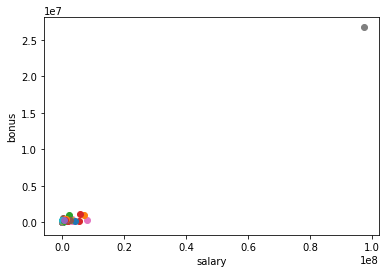

The person with the highest paid salary is:  TOTAL
Highest paid salary:  26704229


In [8]:
### Task 2: Remove outliers

#Plot showing outlier
features=['bonus', 'salary']
data = featureFormat(data_dict, features)
for point in data:
    salary=point[0]
    bonus=point[1]
    plt.scatter(salary,bonus)
plt.xlabel('salary')
plt.ylabel('bonus')
plt.show()


salaries = []

for i in data_dict:
    if type(data_dict[i]['salary'])== int:
        salaries.append(data_dict[i]['salary'])
for i in data_dict:    
    if data_dict[i]['salary'] == max(salaries):
        print "The person with the highest paid salary is: ", i
print "Highest paid salary: ", str(max(salaries))



After plotting the graph we can clearly see an outlier. This outlier happens to be the total salary for the whole dataset. So, since it is not an actual person we will remove it leaving us with 145 real Enron executives.

While we are removing the outliers we will also remove any NaN's from the data set.

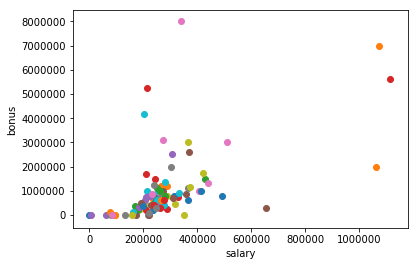

In [9]:
### remove any outliers before proceeding further
features = ["salary", "bonus"]
data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features)

### remove NAN's from dataset
outliers = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers.append((key, int(val)))


#plot after removing the outlier
for point in data:
    salary=point[0]
    bonus=point[1]
    plt.scatter(salary,bonus)
plt.xlabel('salary')
plt.ylabel('bonus')
plt.show()

After removing the outlier we can see the graph is much easier to interpret. There does seem to be a few outliers but these may also be our poi's. Let's take a look at the top four salaries and determine if any are known poi's.



In [10]:
highest_sal = sorted(outliers,key =lambda x:x[1], reverse=True)[:4]


print "The top 4 highest salary holders are: ", highest_sal

The top 4 highest salary holders are:  [('SKILLING JEFFREY K', 1111258), ('LAY KENNETH L', 1072321), ('FREVERT MARK A', 1060932), ('PICKERING MARK R', 655037)]


In [11]:
#determine if they are poi's
print "The following are POI's among our top 4 outliers: "
for person in highest_sal:
    if data_dict[person[0]]['poi'] == 1:
        print person[0]

The following are POI's among our top 4 outliers: 
SKILLING JEFFREY K
LAY KENNETH L


Now we can see that some of the outliers are indeed POI's and thus we won't need any further cleaning of the data. So, with the data cleaned to where we need it we can now move on to feature processing.

## 2. Feature Processing

Now that we have finished cleaning and removing outliers from the we can start creating a predicative algorithm to find POI's. We'll start but seeing how well the original features can predict a potential POI. After we discover a baseline of accuracy we will try to improve it by creating new features of our own.



In [12]:
#data_dict = pickle.load(open("../final_project/final_project_dataset.pkl", "r") )

features_list = ['poi','salary', 'from_poi_to_this_person', 'from_this_person_to_poi', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'director_fees', 'deferred_income', 'long_term_incentive']

data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)


#split data into traing and testing sets
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size= 0.4, random_state = 42)

#utlize decision tree
from sklearn.tree import DecisionTreeClassifier
t0 = time()
clf = DecisionTreeClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

from sklearn.metrics import accuracy_score
acc= accuracy_score(labels_test, pred)
print 'Accuracy:  ' , str(acc)
print 'Precision:  ', precision_score(labels_test, pred)
print 'Recall:  ', recall_score(labels_test, pred)
print 'Decision Tree run time:  ', round(time()-t0, 3), 's'

Accuracy:   0.689655172414
Precision:   0.0833333333333
Recall:   0.125
Decision Tree run time:   0.078 s


Using the given features we obtain an accuracy of about 71%. Next we will make a list that shows the importance of each feature. With this we can decide which features are worth keeping around.

In [13]:
import numpy as np

importance = clf.feature_importances_
index = np.argsort(importance)[::-1]

for i in range(18):
    print "{} Feature {} ({})".format(i+1, features_list[i+1], importance[index[i]])


1 Feature salary (0.303225638483)
2 Feature from_poi_to_this_person (0.29588894485)
3 Feature from_this_person_to_poi (0.28100877193)
4 Feature to_messages (0.0991310307018)
5 Feature deferral_payments (0.0207456140351)
6 Feature total_payments (0.0)
7 Feature exercised_stock_options (0.0)
8 Feature bonus (0.0)
9 Feature restricted_stock (0.0)
10 Feature shared_receipt_with_poi (0.0)
11 Feature restricted_stock_deferred (0.0)
12 Feature total_stock_value (0.0)
13 Feature expenses (0.0)
14 Feature loan_advances (0.0)
15 Feature from_messages (0.0)
16 Feature other (0.0)
17 Feature director_fees (0.0)
18 Feature deferred_income (0.0)


After establishing a ranking we can see that there are several features that contribute very little to our accuracy. We will be leaving these features out from further calculations.

Next let's create our new features and see if we can improve on the accuracy measures.

In [14]:
### Task 3: Create new feature(s)

### create new features
### poi_per_to_msg = (from_poi_to_this_person)/(to_messages)
### poi_per_from_msg = (from_this_person_to_poi)/(from_messages)

def dict_to_list(key,normalizer):
    new_list=[]

    for i in data_dict:
        if data_dict[i][key]=="NaN" or data_dict[i][normalizer]=="NaN":
            new_list.append(0.)
        elif data_dict[i][key]>=0:
            new_list.append(float(data_dict[i][key])/float(data_dict[i][normalizer]))
    return new_list

### creating new list of features
poi_per_to_msg=dict_to_list("from_poi_to_this_person","to_messages")
poi_per_from_msg=dict_to_list("from_this_person_to_poi","from_messages")

### insert new features into data_dict
count=0
for i in data_dict:
    data_dict[i]["poi_per_to_msg"]=poi_per_to_msg[count]
    data_dict[i]["poi_per_from_msg"]=poi_per_from_msg[count]
    count +=1

#test
#print data_dict['SKILLING JEFFREY K']['poi_per_to_msg']

## 3. Applying Learning Algorithms


Now that we created our new features that we want to explore lets take a look at how accurate our creations are at identifying poi's.

In [15]:
### Store to my_dataset for easy export below.
my_dataset = data_dict
features_list = ['poi','poi_per_to_msg','poi_per_from_msg','salary', 'from_poi_to_this_person', 'from_this_person_to_poi', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'from_messages', 'director_fees', 'deferred_income', 'long_term_incentive']


### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list)

## split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)


#Provided to give you a starting point. Try a variety of classifiers.
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.1, random_state=42)

#t0 = time()
clf =DecisionTreeClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

acc = accuracy_score(labels_test, pred)
print 'Accuracy:  ' + str(acc)
print 'Precision:  ', precision_score(labels_test, pred)
print 'Recall:  ', recall_score(labels_test, pred)
#print 'Run Time:  ', round(time()-t0, 3), 's'


Accuracy:  0.8
Precision:   0.666666666667
Recall:   0.5


After adding our new features it appears that the precision has increased but the accuracy and recall haven't gotten to a desirable value. Let's recheck the features using SelectKBest. This should help narrow down the features a bit better than relying on my own intuition. We'll also produce a graph of the feature scores. This will help us look for any noteable dropoffs in scores were we can divide the ones we will keep against the ones we'll drop.

SelectKBest takes in all of the features and returns the top 10 by default. But as noted above we'll use a graph to help determine which features are worth keeping. This helps because if we were to blindly take just the top 10 features we would be missing out on the 11th feature which may be close in importance to the 10 feature. Or the 11th feature's importanced may significantly less than the 10th in which we would only use the top 10. After, refining our features this will help us further our accuracy, precision, and recall ratings.



In [16]:
from sklearn.feature_selection import SelectKBest
data_dict = pickle.load(open("../final_project/final_project_dataset.pkl", "r") )

features_list = ['poi','salary', 'poi_per_to_msg', 'poi_per_from_msg', 'from_poi_to_this_person', 'from_this_person_to_poi', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'director_fees', 'deferred_income', 'long_term_incentive']

data= featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.1, random_state=42)


selector = SelectKBest()
selectedFeatures = selector.fit(features, labels)
features_names = [features_list[i] for i in selectedFeatures.get_support(indices=True)]

#print 'The best features to use are: ', features_names

1 Feature salary (25.0975415287)
2 Feature poi_per_to_msg (24.4676540475)
3 Feature poi_per_from_msg (21.0600017075)
4 Feature from_poi_to_this_person (18.575703268)
5 Feature from_this_person_to_poi (16.6417070705)
6 Feature to_messages (11.5955476597)
7 Feature deferral_payments (10.0724545294)
8 Feature total_payments (9.34670079105)
9 Feature exercised_stock_options (8.86672153711)
10 Feature bonus (8.74648553213)
11 Feature restricted_stock (7.24273039654)
12 Feature shared_receipt_with_poi (6.23420114051)
13 Feature restricted_stock_deferred (5.34494152315)
14 Feature total_stock_value (4.2049708583)
15 Feature expenses (3.21076191697)
16 Feature loan_advances (2.42650812724)
17 Feature from_messages (2.10765594328)
18 Feature other (1.69882434858)
19 Feature director_fees (0.21705893034)
20 Feature deferred_income (0.164164498234)
21 Feature long_term_incentive (0.0649843117237)


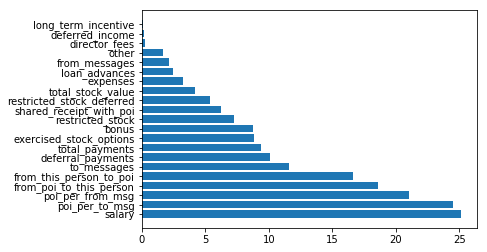

In [17]:
scores = selector.scores_

sorting = np.argsort(scores)[::-1]

#print len(sorting)
#print scores
#std = np.std([scores], axis=0)

for i in range(21):
    print "{} Feature {} ({})".format(i+1, features_list[i+1], scores[sorting[i]])
plt.barh(range(21), scores[sorting])
plt.yticks(range(21), features_list[1:])
plt.show()

After reviewing the ranking and the graph we can see that there are two significant steps down in scores. The first is bewteen **from_this_person_to_poi** and **to_messages** the second large step is between **other** and **director_fees**. In deciding between which drop off mark to use I first found out which pair had the larger percentage gap between the values.

In [18]:
def percent_diff(feature1, feature2):
    if feature1 > feature2:
        diff1 = (1 - (feature2/feature1))*100.0
        return diff1
    if feature1 < feature2:
        diff2 = (1 - (feature1/feature2))*100.0
        return diff2
    
    
print "The difference between 'from_this_person_to_poi' and 'to_messages': %.2f percent" % percent_diff(16.64,11.60)


print "The difference between 'other' and 'director_fees': %.2f percent" % percent_diff(1.70,.22)

The difference between 'from_this_person_to_poi' and 'to_messages': 30.29 percent
The difference between 'other' and 'director_fees': 87.06 percent


As we can see the percentage drop is much higher between **other** and **director_fees**. Given this new inofmation we will make our split here so that any feature with a score less than 1.70 will be left out of our list.

Now that we have a better idea of what features should be used let's see if this achieves the imporvements that we are looking for.

In [19]:
features_list = ['poi','salary', 'poi_per_to_msg', 'poi_per_from_msg', 'from_poi_to_this_person', 'from_this_person_to_poi', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other']# 'director_fees', 'deferred_income', 'long_term_incentive']
data = featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.4, random_state = 42)


In [31]:
clf =DecisionTreeClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

acc = accuracy_score(labels_test, pred)
print 'Accuracy:  ' + str(acc)
print 'Precision:  ', precision_score(labels_test, pred)
print 'Recall:  ', recall_score(labels_test, pred)

Accuracy:  0.717391304348
Precision:   0.0
Recall:   0.0


After using the recommended features our accuracy, precision, and recall scores were more or less flat. So let's see if any other algorithm's will improve on our scores.



### Adaboost

In [21]:
features_list = ['poi','salary', 'poi_per_to_msg', 'poi_per_from_msg', 'from_poi_to_this_person', 'from_this_person_to_poi', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other']# 'director_fees', 'deferred_income', 'long_term_incentive']
data = featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.4, random_state = 42)


from sklearn.ensemble import AdaBoostClassifier

t0 = time()

clf = AdaBoostClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

acc = accuracy_score(labels_test, pred)

print 'Accuracy:  ', str(acc)
print 'Precision:  ' ,precision_score(labels_test, pred)
print 'Recall:  ' ,recall_score(labels_test, pred)

Accuracy:   0.862068965517
Precision:   0.5
Recall:   0.125


Using the Adaboost classifier the accuracy increased but our precision and recall scores fell. This could be a sign of underfitting as the Adaboost algorithm is favoring misidentifying POI's, which is a small part of the dataset, over misidentifying non-POI's, the greater part of the dataset. Because of this let's see if RandomForest will be a better solution versus our DecisionTree.

In [22]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

acc = accuracy_score(labels_test, pred)

print 'Accuracy:  ', str(acc)
print 'Precision:  ', precision_score(labels_test, pred)
print 'Recall:  ', recall_score(labels_test, pred)

Accuracy:   0.879310344828
Precision:   1.0
Recall:   0.125


Using the RandomForestClassifier the accuracy came out as significantly better than Adaboost but Recall fell greatly while precision is 1.0. This could be a sign that the RandomForest classifier is overfitting and not giving us accurate measures. Given this observation it appears that DecisionTree is the best algorithm for our data_set.

## 4. Validating and Algorithm Tuning

Here we will take DecisionTree algor## 4. Validating and Algorithm Tuning

Here we will take DecisionTree algorithm and tune it to see if we improve on our already superior results. Using GridSearchCV as a guide we should be able to find the ideal settings for DecisionTree.

 This is important as tuning the parameters allows us to finely tune the DecisionTree from or towards overfitting of the data. We can also change a parameter like max_depth to determine with features have a chance of becoming a decision node.
 
 This algorithm was validated by using cross-valdiation, precision and recall scores. 
 
It is important to note that, though we have been using accuracy throughout the program it should be avoided in our final validation. This is because the number of POIs is much smaller (18 in our test set, that the total number of executives (145 after cleaning the outlier) in our dataset thus giving our dataset a large imbalance. This creates a problem for machine learning algorithms where the algorithm underfits the data. Without proper tuning the algorithm will miss a large number of our POI's but will correctly identify regular executives as being non-POI's. This leads to a smaller number of total mistakes and gives us a higher accuracy rating. However, in our case this is problematic because we would rather capture more of the POI's at the cost of misidentifying non-POI's. So putting our accuracy score on the back burner and tune to increase our Precision and Recall scores we will capture more of our POI's.


Now, let's tune our algorithm and see if we improve on our results from above. Using GridSearchCV as a guide we should be able to find the ideal settings for DecisionTree

In [85]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html
data = my_dataset
features_list = ['poi','salary', 'poi_per_to_msg', 'poi_per_from_msg', 'from_poi_to_this_person', 'from_this_person_to_poi', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other']# 'director_fees', 'deferred_income', 'long_term_incentive']
data = featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.4, random_state = 70)


parameters = {'min_samples_split': range(2,10), 'max_depth': range(1,19), 'max_features': range(3,12), 'random_state': [60]}
clf = GridSearchCV(DecisionTreeClassifier(), parameters)
clf = clf.fit(features_train, labels_train)

print 'The ideal tuned settings for DecisionTree is: '
print clf.best_estimator_


The ideal tuned settings for DecisionTree is: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=60, splitter='best')


Using GridSearchCV we were able to find the ideal parameters for our DecisionTree. 


### More on validation
The next step is to pass it through our final validation in which we will split the data into a training set and a testing set. The training set allows us to develop the algorithm while the test set tells us how well the algorithm will preform when applied to the full data set. It's important to know that we do not train the data on the test. This is because we would receive an accuracy of 100% but in reality the algorithm would have been poorly trained. 

With that said we used the StratifiedShuffledSplit from the test_classifier function found in test.py. This function works well with small and unbalanced datasets such as the one we are currently working on.



In [87]:
#data = my_dataset
#features_list = ['poi', 'poi_per_to_msg', 'poi_per_from_msg', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'restricted_stock_deferred','total_stock_value','expenses', 'director_fees', 'deferred_income']

#data = featureFormat(my_dataset, features_list)
#labels, features = targetFeatureSplit(data)

from tester import test_classifier
clf_opt = clf.best_estimator_

test_classifier(clf_opt, my_dataset, features_list)

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf_opt, my_dataset, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=60, splitter='best')
	Accuracy: 0.84527	Precision: 0.42496	Recall: 0.45450	F1: 0.43924	F2: 0.44827
	Total predictions: 15000	True positives:  909	False positives: 1230	False negatives: 1091	True negatives: 11770



Even after running GridSearchCV it still took some experimentation to find the right mixture of settings to achieve a the desired Precision and Recall score of better than 0.3. It's important to keep in mind that when viewing these scores 1.0 is the best and 0.0 is the worst.

## Conclusions

Interpretating our precision an recall values helps us determine how well our program is at identifying POI's from other executives. Precision measures false positives or how many executives would be falsely identified as POI's. Given our value of 0.4 this means that 60% of our identified POI's are false alarms. 

Our other measure recall measures false negatives or how many POI's would be misidentified as regular executives. Given our value of .57 this means that we have captured 57% of the time we captured one of the POI's but at the price of misidentifying regular executives. This could be a case of overfitting the data and thus capturing too many points that don't belong in the POI group.

As mentioned in the beginning of this paper I attempted to use financial data but the precision and recall was far below our threshold value of 0.3. This means that using the financial parameters I created was very inefficient. With this said further looking into the actual words used in the emails to/from the POI's could help keep our 33% of innocent executives safe from prosecution. Using a data set of keywords used between executives and the POI's would make our algorithm even more accurate.

Notes on feature scaling:

In this case we did not use feature scaling, meaning we did not scale down/up a feature that has more/less data points in relationship to the other features. This is because DecisionTree does not need feature scaling as it splits based on each feature independently. Thus, scaling the features would be inappropiate for our chosen algorithm. 